In [1]:
# Pandas
import pandas as pd

# Configuração do matplotlib
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Sklearn e Skforecast
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from pmdarima.arima import auto_arima

In [2]:
# Carrega dados
data = pd.read_csv("C:\\fatec\\mineda\\india.csv", usecols=['date','Potatoes'])
data.head(5)

,date,Potatoes
0,2000-02,4.933333
1,2000-03,4.365000
2,2000-04,4.742500
3,2000-05,4.855000
4,2000-06,5.090000


In [3]:
# ve o tipo do dado, para tratamento
data.dtypes

date         object
Potatoes    float64
dtype: object

In [4]:
# Tratamento de dados
# Converte data de string para datetime e transforma em índice
data['date'] = pd.to_datetime(data['date'], format='%Y-%m') # format='%m-%d-%Y

In [5]:
data.dtypes

date        datetime64[ns]
Potatoes           float64
dtype: object

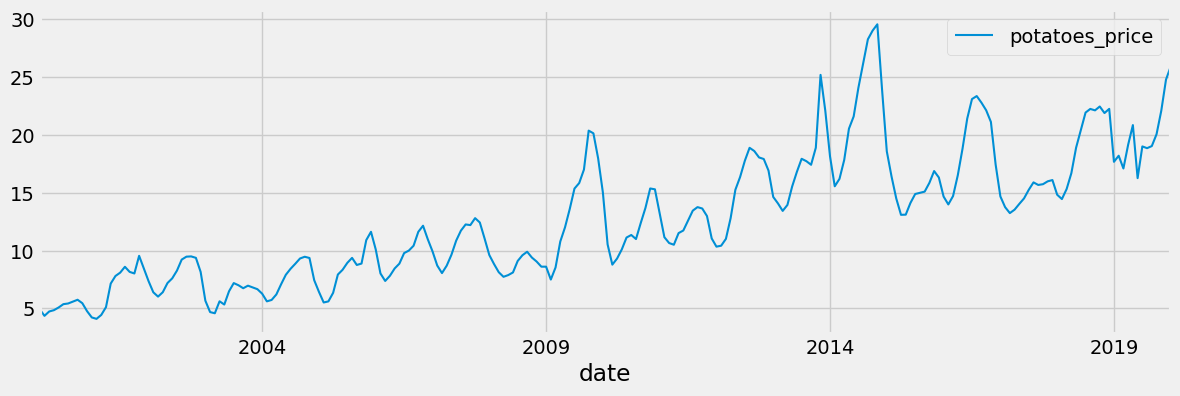

In [6]:
# Renomeia a coluna com os preços de batata
data = data.rename(columns={'Potatoes': 'potatoes_price'})
# Seto o índice
data = data.set_index('date')
data = data.asfreq('MS', fill_value=0.0)
data = data.sort_index()
# Defino a frequência (Mensal). Caso falte registro, cria um novo e preenche as demais colunas com 0.0
# data = data.asfreq('MS', fill_value=0.0)
# Ordena pela data

# Plota os dados
fig, ax = plt.subplots(figsize=(13, 4))
data['potatoes_price'].plot(ax=ax, label='potatoes_price')
ax.legend();

In [133]:
print(f'Number of rows with missing values: {data.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.0


In [7]:
# Código para verificar se não existem "buracos" nos dados
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

Train dates : 2000-02-01 00:00:00 --- 2017-01-01 00:00:00  (n=204)
Test dates  : 2017-02-01 00:00:00 --- 2020-01-01 00:00:00  (n=36)


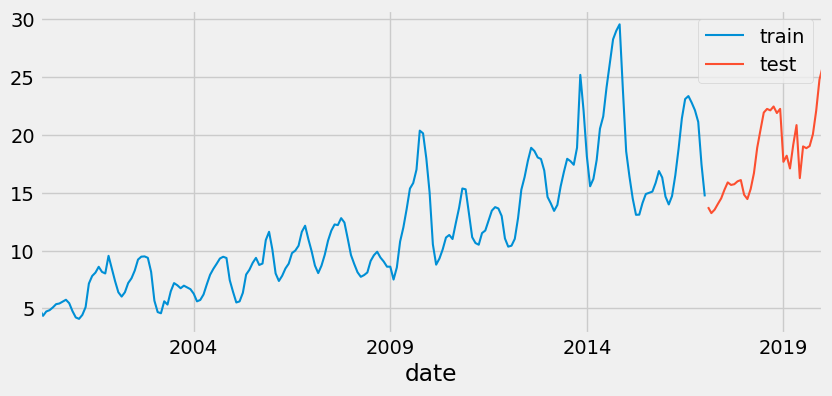

In [8]:
# Divide dados em treinamento e teste
# Para séries temporais, sempre utilizamos os dados mais recentes para teste
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Plotando os dados
fig, ax=plt.subplots(figsize=(9, 4))
data_train['potatoes_price'].plot(ax=ax, label='train')
data_test['potatoes_price'].plot(ax=ax, label='test')
ax.legend();

In [9]:
# Configura e treina um RandomForestRegressor para série temporal
# Os parâmetros foram retirados do melhor modelo encontrado no material de origem
# Para conseguir os melhores parâmetros se faz necessário realizer hyperparameter tunning (verifique artigo original)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=30, n_estimators=365, random_state=123),
                lags      = 12
             )

forecaster.fit(y=data_train['potatoes_price'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=30, n_estimators=365, random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2000-02-01 00:00:00'), Timestamp('2017-01-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 365, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-06-04 15:19:33 
La

In [10]:
# Faz predição no conjunto de teste
steps = 36
predictions = forecaster.predict(steps=steps)
predictions.head(5)

2017-02-01    13.704250
2017-03-01    13.755723
2017-04-01    13.956255
2017-05-01    14.317347
2017-06-01    14.421835
Freq: MS, Name: pred, dtype: float64

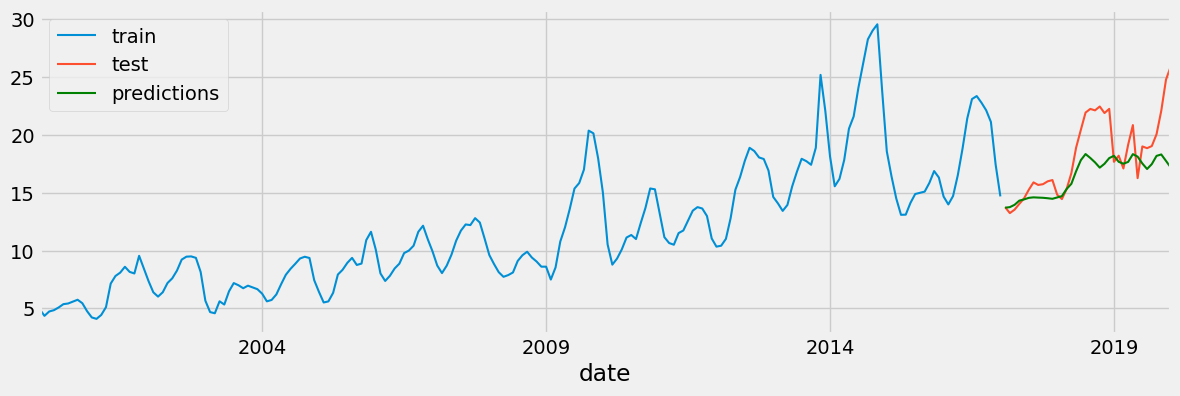

In [11]:
# Plota a predição, comparando com valores reais
fig, ax=plt.subplots(figsize=(13, 4))
data_train['potatoes_price'].plot(ax=ax, label='train')
data_test['potatoes_price'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions', color='green')
ax.legend();

In [12]:
# O ARIMA vem com um tunning automático, o auto_arima
model = auto_arima(data_train['potatoes_price'], trace=True, error_action='ignore', suppress_warnings=True)
# Treina o modelo
model.fit(data_train['potatoes_price'])
# Previsao
forecast = model.predict(n_periods=len(data_test))
# Converte para um dataframe
forecast = pd.DataFrame(forecast,index = data_test.index,columns=['Prediction'])
forecast

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=720.830, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=649.855, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=651.036, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=719.064, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=639.118, Time=0.02 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=639.742, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=642.475, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=637.207, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=647.877, Time=0.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=637.862, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=620.105, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=640.523, Time=0.0

,Prediction
date,
2017-02-01,13.503713
2017-03-01,13.560608
2017-04-01,14.393376
2017-05-01,15.554745
2017-06-01,16.693974
2017-07-01,17.591838
2017-08-01,18.156700
2017-09-01,18.396554
2017-10-01,18.381329


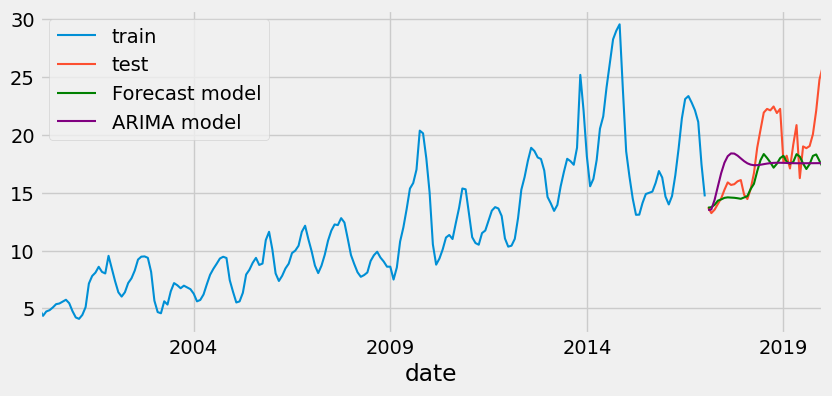

In [13]:
# Plota a predição, comparando com valores reais e modelos Forecast e ARIMA
fig, ax=plt.subplots(figsize=(9, 4))
data_train['potatoes_price'].plot(ax=ax, label='train')
data_test['potatoes_price'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='Forecast model', color='green')
forecast['Prediction'].plot(ax=ax, label='ARIMA model', color='purple')
ax.legend();